# Precomptued Analysis

Use precomputed optimal angles to measure the expected value of $\langle C \rangle$ across a variety of problem types, sizes, $p$-depth, and random instances.

## Load in Raw Data
Go through each record, load in supporting objects, flatten everything into records, and put into a massive dataframe.

In [1]:
import recirq
import cirq
import numpy as np
import pandas as pd
from recirq.qaoa.experiments.precomputed_execution_tasks import \
    DEFAULT_BASE_DIR, DEFAULT_PROBLEM_GENERATION_BASE_DIR, DEFAULT_PRECOMPUTATION_BASE_DIR

records = []
for record in recirq.iterload_records(dataset_id="2020-03-tutorial", base_dir=DEFAULT_BASE_DIR):
    dc_task = record['task']
    apre_task = dc_task.precomputation_task
    pgen_task = apre_task.generation_task
    
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    record['optimum'] = recirq.load(apre_task, base_dir=DEFAULT_PRECOMPUTATION_BASE_DIR)['optimum']
    record['bitstrings'] = record['bitstrings'].bits
    recirq.flatten_dataclass_into_record(record, 'task')
    recirq.flatten_dataclass_into_record(record, 'precomputation_task')    
    recirq.flatten_dataclass_into_record(record, 'generation_task')    
    recirq.flatten_dataclass_into_record(record, 'optimum')
    records.append(record)
df_raw = pd.DataFrame(records)    
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw.head()

,timestamp,bitstrings,qubits,final_qubits,circuit,violation_indices,problem,problem_type,dataset_id,device_name,...,generation_task.dataset_id,generation_task.device_name,instance_i,n_qubits,optimum.p,f_val,gammas,betas,min_c,max_c
0,2020-04-08 13:11:32.151452,"[[0, 0, 0, 0], [0, 0, 1, 0], [1, 1, 1, 1], [0,...","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(PhX(-0.824)^0.5((5, 3)), PhX(-0.824)^0.5((6,...",[],"(2, 0, 1, 3)",HardwareGridProblem,2020-03-tutorial,Syc23-simulator,...,2020-03-tutorial,Sycamore23,4,4,2,-2.616073,"[0.47109541452232295, 0.5900885654628348]","[-0.44860990386986666, -0.29400122107756244]",-3.0,3.0
1,2020-04-08 13:11:32.520129,"[[0, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [1,...","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(PhX(-0.644)^0.39663553581308286((5, 3)), PhX...",[],"(2, 0, 1, 3)",HardwareGridProblem,2020-03-tutorial,Syc23-simulator,...,2020-03-tutorial,Sycamore23,4,4,3,-3.000000,"[0.3047317419709853, 0.6664224586095869, 0.607...","[-0.5760240058080092, -0.36261585803438645, -0...",-3.0,3.0
2,2020-04-08 13:11:31.499590,"[[0, 0, 0, 0], [1, 0, 1, 1], [0, 1, 0, 0], [1,...","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(5, 3), (6, 2), (6, 3), (6, 4)]","[(PhX(0.806)^0.3587079604881125((5, 3)), PhX(0...",[],"(2, 0, 1, 3)",HardwareGridProblem,2020-03-tutorial,Syc23-simulator,...,2020-03-tutorial,Sycamore23,4,4,1,-1.632993,[0.4776585668842565],[-0.3926990816996555],-3.0,3.0
3,2020-04-08 13:11:31.077127,"[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0...","[(5, 3), (6, 3)]","[(5, 3), (6, 3)]","[(PhX(0.163)^0.27171459224559236((5, 3)), PhX(...",[],"(1, 0)",HardwareGridProblem,2020-03-tutorial,Syc23-simulator,...,2020-03-tutorial,Sycamore23,4,2,2,-1.000000,"[0.6283182637521854, 0.7853973288957912]","[-0.3926989532796281, -0.07854016690845925]",-1.0,1.0
4,2020-04-08 13:11:31.247321,"[[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0...","[(5, 3), (6, 3)]","[(5, 3), (6, 3)]","[(PhX(-0.14)^0.5((5, 3)), PhX(-0.5)^0.5((6, 3)...",[],"(1, 0)",HardwareGridProblem,2020-03-tutorial,Syc23-simulator,...,2020-03-tutorial,Sycamore23,4,2,3,-1.000000,"[0.5620701143250424, 0.7076351823020001, 0.798...","[-0.4199391572618354, -0.1086414306397252, -0....",-1.0,1.0


## Narrow down to Relevant Data
Drop unnecessary metadata and use bitstrings to compute the expected value of the energy. In general, it's better to save the raw data and lots of metadata so we can use it if it becomes necessary in the future.

In [2]:
from recirq.qaoa.simulation import hamiltonian_objectives, hamiltonian_objective_avg_and_err
import cirq.google as cg

def compute_energy_w_err(row):
    permutation = []
    for i, q in enumerate(row['qubits']):
        fi = row['final_qubits'].index(q)
        permutation.append(fi)
    
    energy, err = hamiltonian_objective_avg_and_err(row['bitstrings'], row['problem'], permutation)
    return pd.Series([energy, err], index=['energy', 'err'])
    

# Start cleaning up the raw data
df = df_raw.copy()

# Don't need these columns for present analysis
df = df.drop(['gammas', 'betas', 'circuit', 'violation_indices',
              'precomputation_task.dataset_id',
              'generation_task.dataset_id',
              'generation_task.device_name'], axis=1)

# p is specified twice (from a parameter and from optimum)
assert (df['optimum.p'] == df['p']).all()
df = df.drop('optimum.p', axis=1)

# Compute energies
df = df.join(df.apply(compute_energy_w_err, axis=1))
df = df.drop(['bitstrings', 'qubits', 'final_qubits', 'problem'], axis=1)

# Normalize
df['energy_ratio'] = df['energy'] / df['min_c']
df['err_ratio'] = df['err'] * np.abs(1/df['min_c'])
df['f_val_ratio'] = df['f_val'] / df['min_c']

df

,timestamp,problem_type,dataset_id,device_name,n_shots,structured,echoed,p,instance_i,n_qubits,f_val,min_c,max_c,energy,err,energy_ratio,err_ratio,f_val_ratio
0,2020-04-08 13:11:32.151452,HardwareGridProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,2,4,4,-2.616073,-3.0,3.0,-1.89004,0.007524,0.630013,0.002508,0.872024
1,2020-04-08 13:11:32.520129,HardwareGridProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,3,4,4,-3.000000,-3.0,3.0,-1.85736,0.007451,0.619120,0.002484,1.000000
2,2020-04-08 13:11:31.499590,HardwareGridProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,1,4,4,-1.632993,-3.0,3.0,-1.39456,0.007291,0.464853,0.002430,0.544331
3,2020-04-08 13:11:31.077127,HardwareGridProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,2,4,2,-1.000000,-1.0,1.0,-0.89096,0.002031,0.890960,0.002031,1.000000
4,2020-04-08 13:11:31.247321,HardwareGridProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,3,4,2,-1.000000,-1.0,1.0,-0.85592,0.002313,0.855920,0.002313,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2020-04-08 13:08:23.360051,SKProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,3,0,7,-7.888209,-9.0,11.0,-1.53480,0.020784,0.170533,0.002309,0.876468
146,2020-04-08 13:08:16.029073,SKProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,1,0,7,-5.318905,-9.0,11.0,-3.02000,0.019369,0.335556,0.002152,0.590989
147,2020-04-08 13:09:02.773520,SKProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,2,1,7,-6.942368,-9.0,11.0,-2.36920,0.020491,0.263244,0.002277,0.771374
148,2020-04-08 13:09:06.524879,SKProblem,2020-03-tutorial,Syc23-simulator,50000,True,False,3,1,7,-7.888209,-9.0,11.0,-1.50696,0.020841,0.167440,0.002316,0.876468


## Plots

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('ticks')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

# theme colors
QBLUE = '#1967d2'
QRED = '#ea4335ff'
QGOLD = '#fbbc05ff'
QGREEN = '#34a853ff'

QGOLD2 = '#ffca28'
QBLUE2 = '#1e88e5'

In [4]:
C = r'\langle C \rangle'
CMIN = r'C_\mathrm{min}'
COVERCMIN = f'${C}/{CMIN}$'

In [5]:
def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

### Raw swarm plots of all data

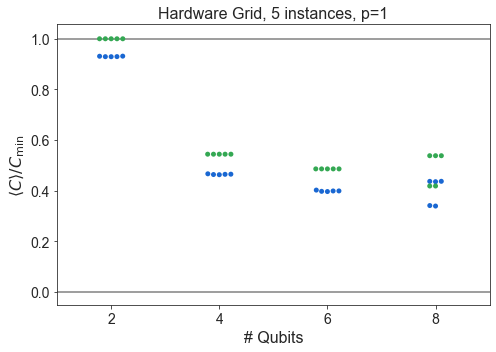

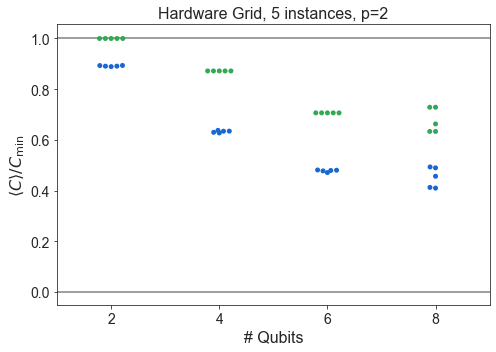

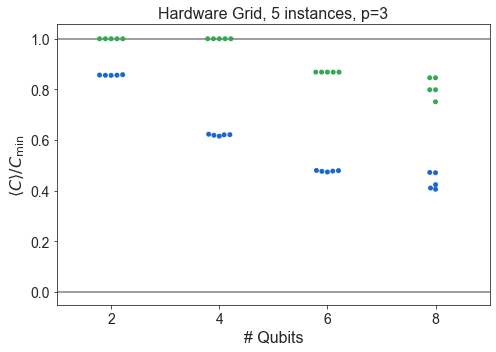

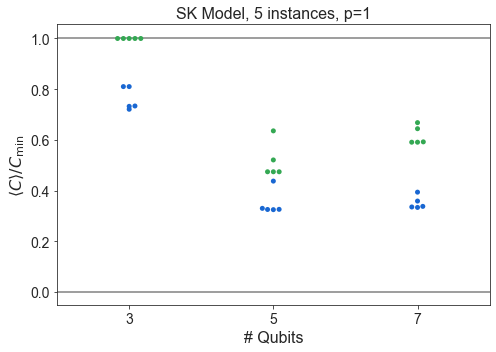

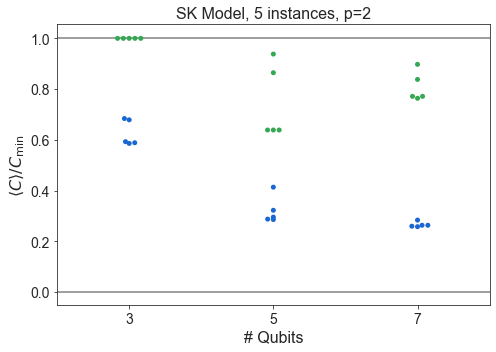

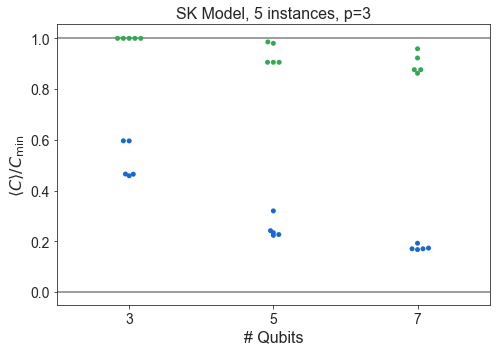

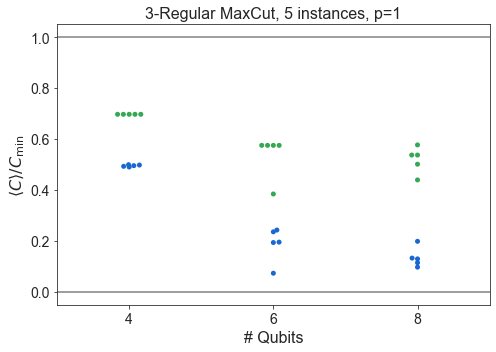

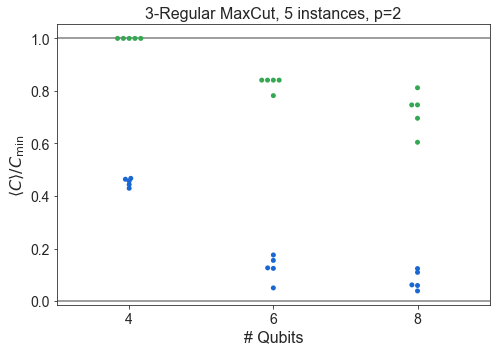

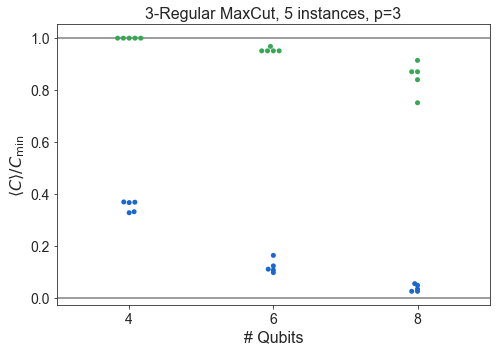

In [6]:
import numpy as np
from matplotlib import pyplot as plt

pretty_problem = {
    'HardwareGridProblem': 'Hardware Grid',
    'SKProblem': 'SK Model',
    'ThreeRegularProblem': '3-Regular MaxCut'
}

for problem_type in ['HardwareGridProblem', 'SKProblem', 'ThreeRegularProblem']:
    df1 = df
    df1 = df1[df1['problem_type'] == problem_type]

    for p in sorted(df1['p'].unique()):
        dfb = df1
        dfb = dfb[dfb['p'] == p]
        dfb = dfb.sort_values(by='n_qubits')    

        plt.subplots(figsize=(7,5))

        n_instances = dfb.groupby('n_qubits').count()['energy_ratio'].unique()
        if len(n_instances) == 1:
            n_instances = n_instances[0]
            label = f'{n_instances}'
        else:
            label = f'{min(n_instances)} - {max(n_instances)}'

        #sns.boxplot(dfb['n_qubits'], dfb['energy_ratio'], color=QBLUE, saturation=1)
        #sns.boxplot(dfb['n_qubits'], dfb['f_val_ratio'], color=QGREEN, saturation=1)
        sns.swarmplot(dfb['n_qubits'], dfb['energy_ratio'], color=QBLUE)
        sns.swarmplot(dfb['n_qubits'], dfb['f_val_ratio'], color=QGREEN)

        plt.axhline(1, color='grey', ls='-')
        plt.axhline(0, color='grey', ls='-')

        plt.title(f'{pretty_problem[problem_type]}, {label} instances, p={p}')
        plt.xlabel('# Qubits')
        plt.ylabel(COVERCMIN)
        plt.tight_layout()
        plt.show()


### Compare SK and Hardware Grid vs. $n$

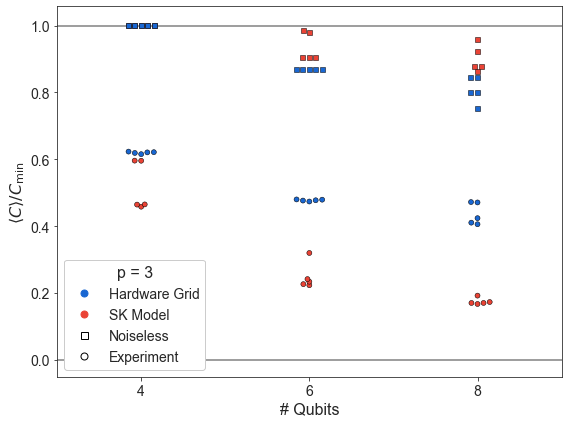

In [7]:
pretty_problem = {
    'HardwareGridProblem': 'Hardware Grid',
    'SKProblem': 'SK Model',
    'ThreeRegularProblem': '3-Regular MaxCut'
}

df1 = df
df1 = df1[
    ((df1['problem_type'] == 'SKProblem') & (df1['p'] == 3))
    | ((df1['problem_type'] == 'HardwareGridProblem') & (df1['p'] == 3))
    ]
df1 = df1.sort_values(by='n_qubits')

MINQ = 3
df1 = df1[df1['n_qubits'] >= MINQ]

plt.subplots(figsize=(8, 6))
plt.xlim((8, 23))

# SK
dfb = df1
dfb = dfb[dfb['problem_type'] == 'SKProblem']
sns.swarmplot(dfb['n_qubits'], dfb['energy_ratio'], s=5, linewidth=0.5, edgecolor='k', color=QRED)
sns.swarmplot(dfb['n_qubits'], dfb['f_val_ratio'], s=5, linewidth=0.5, edgecolor='k', color=QRED,
              marker='s')
dfg = dfb.groupby('n_qubits').mean().reset_index()
# --------


# Hardware
dfb = df1
dfb = dfb[dfb['problem_type'] == 'HardwareGridProblem']
sns.swarmplot(dfb['n_qubits'], dfb['energy_ratio'], s=5, linewidth=0.5, edgecolor='k', color=QBLUE)
sns.swarmplot(dfb['n_qubits'], dfb['f_val_ratio'], s=5, linewidth=0.5, edgecolor='k', color=QBLUE,
              marker='s')
dfg = dfb.groupby('n_qubits').mean().reset_index()
# -------


plt.axhline(1, color='grey', ls='-')
plt.axhline(0, color='grey', ls='-')

plt.xlabel('# Qubits')
plt.ylabel(COVERCMIN)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

lelements = [
    Line2D([0], [0], color=QBLUE, marker='o', ms=7, ls='', ),
    Line2D([0], [0], color=QRED, marker='o', ms=7, ls='', ),

    Line2D([0], [0], color='k', marker='s', ms=7, ls='', markerfacecolor='none'),
    Line2D([0], [0], color='k', marker='o', ms=7, ls='', markerfacecolor='none'),
]

plt.legend(lelements, ['Hardware Grid', 'SK Model', 'Noiseless', 'Experiment', ], loc='best',
           title=f'p = 3',
           handler_map={tuple: HandlerTuple(ndivide=None)}, framealpha=1.0)
plt.tight_layout()
plt.show()

### Hardware Grid vs. $p$

In [8]:
dfb = df
dfb = dfb[dfb['problem_type'] == 'HardwareGridProblem']
dfb = dfb[['p', 'instance_i', 'n_qubits', 'energy_ratio', 'f_val_ratio']]
P_LIMIT = max(dfb['p'])

def max_over_p(group):
    i = group['energy_ratio'].idxmax()
    return group.loc[i][['energy_ratio', 'p']]

def count_p(group):
    new = {}
    for i, c in enumerate(np.bincount(group['p'], minlength=P_LIMIT+1)):
        if i == 0:
            continue
        new[f'p{i}'] = c
    return pd.Series(new)
    

dfgy = dfb.groupby(['n_qubits', 'instance_i']).apply(max_over_p).reset_index()
dfgz = dfgy.groupby(['n_qubits']).apply(count_p).reset_index()
# In the paper, we restrict to n > 10
# dfgz = dfgz[dfgz['n_qubits'] > 10]
dfgz = dfgz.set_index('n_qubits').sum(axis=0)
dfgz /= (dfgz.sum())
dfgz

p1    0.25
p2    0.60
p3    0.15
dtype: float64

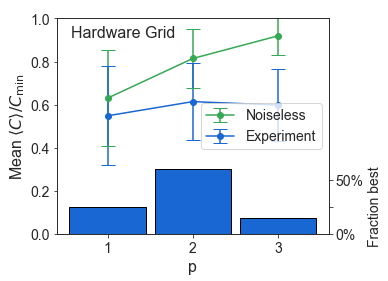

In [10]:
dfb = df
dfb = dfb[dfb['problem_type'] == 'HardwareGridProblem']
dfb = dfb[['p', 'instance_i', 'n_qubits', 'energy_ratio', 'f_val_ratio']]
# In the paper, we restrict to n > 10
# dfb = dfb[dfb['n_qubits'] > 10]
dfg = dfb.groupby('p').agg(['median', percentile(25), percentile(75), 'mean', 'std']).reset_index()

plt.subplots(figsize=(5.5,4))
plt.errorbar(x=dfg['p'], y=dfg['f_val_ratio', 'mean'],
             yerr=(dfg['f_val_ratio', 'std'],
                   dfg['f_val_ratio', 'std']),
             fmt='o-',
             capsize=7,
             color=QGREEN,
             label='Noiseless'
           )
plt.errorbar(x=dfg['p'], y=dfg['energy_ratio', 'mean'],
             yerr=(dfg['energy_ratio', 'std'],
                   dfg['energy_ratio', 'std']),
             fmt='o-',
             capsize=7,
             color=QBLUE,
             label='Experiment'
           )
plt.xlabel('p')
plt.ylabel('Mean ' + COVERCMIN)
plt.ylim((0, 1))
plt.text(0.05, 0.9, r'Hardware Grid', fontsize=16, transform=plt.gca().transAxes, ha='left', va='bottom')
plt.legend(loc='center right')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis

dfgz_p = [int(s[1:]) for s in dfgz.index]
dfgz_y = dfgz.values
ax2.bar(dfgz_p, dfgz_y, color=QBLUE, width=0.9, lw=1, ec='k')
ax2.tick_params(axis='y')
ax2.set_ylim((0, 2))
ax2.set_yticks([0, 0.25, 0.50])
ax2.set_yticklabels(['0%', None, '50%'])
ax2.set_ylabel('Fraction best' + ' ' * 41, fontsize=14)

plt.tight_layout()